This notebook contains the random forest model fitting and evaluation for syllable data

Used for pose estimation: Pereira, Talmo D., et al. Sleap: Multi-Animal Pose Tracking, 2 Sept. 2020, https://doi.org/10.1101/2020.08.31.276246. 
Used to generate syllable data from pose data: Weinreb, Caleb, et al. Keypoint-MoSeq: Parsing Behavior by Linking Point Tracking to Pose Dynamics, 17 Mar. 2023, https://doi.org/10.1101/2023.03.16.532307. 

In [1]:
# Required packages
import pandas as pd
import numpy as np

import sklearn
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import RandomizedSearchCV, train_test_split
from scipy.stats import randint
from sklearn.preprocessing import OrdinalEncoder
from sklearn.model_selection import train_test_split
from sklearn import metrics

from sklearn.tree import export_graphviz
from IPython.display import Image
import seaborn as sns
import matplotlib.pyplot as plt
import graphviz
import os
os.environ["PATH"] += os.pathsep + r"C:\Users\irs3th\Graphviz-11.0.0-win64\bin"

ModuleNotFoundError: No module named 'graphviz'

In [2]:
# Read the CSV file from Keypoint-Moseq
behaviors = pd.read_csv("behavior_results.csv")
df = behaviors.dropna()

In [3]:
# Drop coulmns that contain all 0s and external sensor data 
columns_to_drop = ['sniff-sniff', 'turn-turn', 'run-run', 'np-np', 'sb-sb', 'groom-groom','wheel_sensor', 'food_sensor']  #water?
df = df.drop(columns=columns_to_drop)
#df

In [5]:
# Initialize OrdinalEncoder to map categories to numeric values 
ord_enc = OrdinalEncoder()

# Group
df.loc[:, "group"] = ord_enc.fit_transform(df[["group"]])
df['group'] = df['group'].astype(int)

# ID
df.loc[:, "id"] = ord_enc.fit_transform(df[["id"]])
df['id'] = df['id'].astype(int)

# Sex
df.loc[:, "sex"] = ord_enc.fit_transform(df[["sex"]])
df['sex'] = df['sex'].astype(int)

#df

In [6]:
# correlations between the features
sns.heatmap(df.corr(),
                xticklabels=df.columns,
                yticklabels=df.columns);

NameError: name 'sns' is not defined

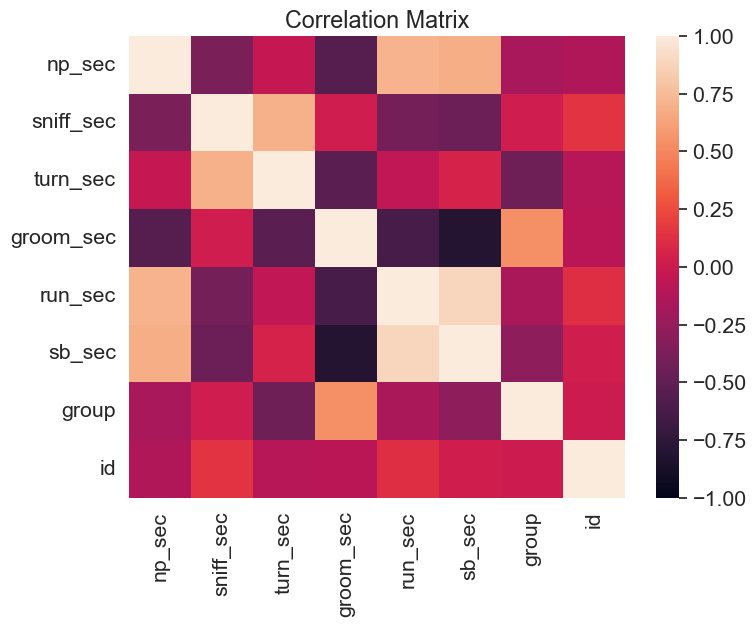

In [103]:
# Filtering out some columns to simplify 
columns_to_keep = [col for col in df.columns if col.endswith('_sec')] + ['group', 'id']
df_filtered = df[columns_to_keep]
corr_matrix = df_filtered.corr()

plt.figure(figsize=(8, 6))  
sns.heatmap(corr_matrix, annot=False, xticklabels=corr_matrix.columns, yticklabels=corr_matrix.columns,
           vmin=-1, vmax=1)
plt.title('Correlation Matrix')  
plt.show()

In [104]:
# Splitting the data and creating a model
X = df.iloc[:, 3:] # all but id, sex, and group columns 
y = df['group']
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3, random_state=100)

forest = RandomForestClassifier(n_estimators=4, random_state=100) #modify as needed

In [105]:
# Fitting a model and making predictions
forest.fit(X_train,y_train)
predictions = forest.predict(X_test)

In [106]:
# Evaluating the model
print("Accuracy:", metrics.accuracy_score(y_test, predictions))
print("Precision:", metrics.precision_score(y_test, predictions, average='micro')) #weighted takes into account support for each label
print("Recall:", metrics.recall_score(y_test, predictions, average='micro')) 

Accuracy: 0.5
Precision: 0.5
Recall: 0.5


In [107]:
# Sort features by importance 
importance = forest.feature_importances_
columns = X_train.columns
rf_cof = pd.Series(importance, columns) 

non_zero_rf_cof = rf_cof[rf_cof != 0].dropna() # filter out columns = 0
non_zero_rf_cof.sort_values(ascending=False)

turn-sniff      0.158489
sb_sec          0.144928
turn-sb         0.133333
sb-run          0.130952
groom_sec       0.116667
run-turn        0.110870
sniff_sec       0.081159
sniff-np        0.071429
groom-turn      0.052174
np-sniff        0.000000
run_freq        0.000000
sb-sniff        0.000000
sb-turn         0.000000
sb-groom        0.000000
groom_freq      0.000000
sniff_freq      0.000000
np_freq         0.000000
run-sb          0.000000
sb_freq         0.000000
turn_freq       0.000000
np_sec          0.000000
turn_sec        0.000000
run_sec         0.000000
sb-np           0.000000
run-sniff       0.000000
run-groom       0.000000
np-turn         0.000000
np-groom        0.000000
np-run          0.000000
np-sb           0.000000
sniff-turn      0.000000
sniff-groom     0.000000
sniff-run       0.000000
sniff-sb        0.000000
turn-np         0.000000
turn-groom      0.000000
turn-run        0.000000
groom-np        0.000000
groom-sniff     0.000000
groom-run       0.000000


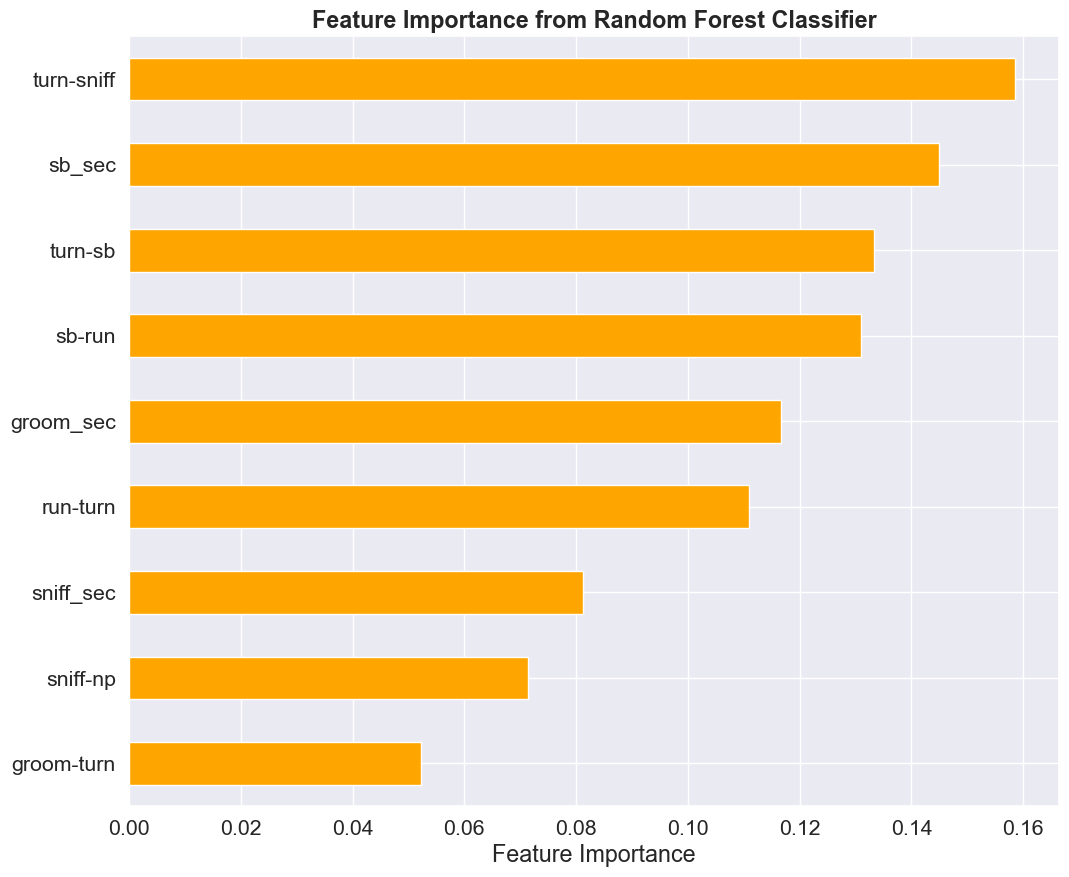

In [109]:
# horizontal bar chart showing feature importance 
plt.figure(figsize=(12, 10))
non_zero_rf_cof.sort_values().plot.barh(color='orange')
plt.xlabel('Feature Importance')
plt.title('Feature Importance from Random Forest Classifier', weight='bold')
plt.show()

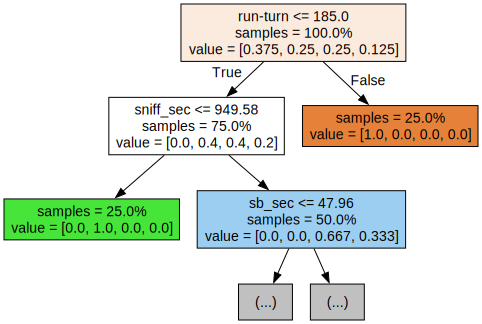

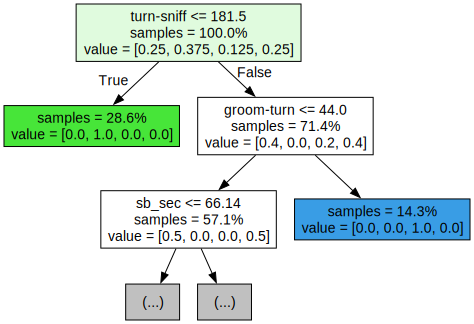

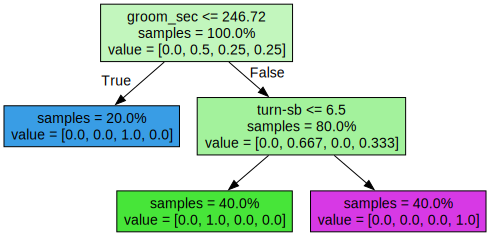

In [110]:
# Show the first three decision trees from the forest
for i in range(3): 
    tree = forest.estimators_[i]
    dot_data = export_graphviz(tree,
                               feature_names=X_train.columns,  
                               filled=True,  
                               max_depth=2, 
                               impurity=False, 
                               proportion=True)
    graph = graphviz.Source(dot_data)
    display(graph)

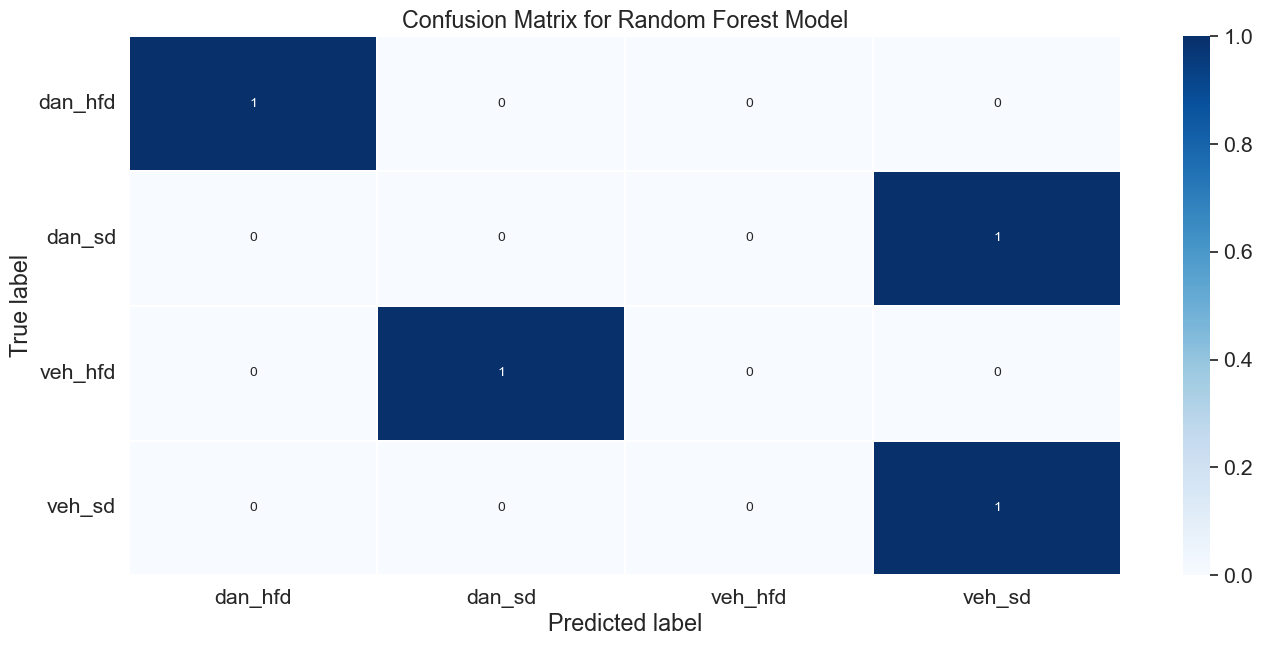

In [111]:
# Confusion matrix of predictions
matrix = confusion_matrix(y_test, predictions)
matrix = matrix.astype('float') / matrix.sum(axis=1)[:, np.newaxis]

plt.figure(figsize=(16,7))
sns.set(font_scale=1.4)
sns.heatmap(matrix, annot=True, annot_kws={'size':10},
            cmap='Blues', linewidths=0.2)

class_names = ['dan_hfd', 'dan_sd', 'veh_hfd', 
               'veh_sd']

tick_marks = np.arange(len(class_names))
tick_marks2 = tick_marks + 0.5
plt.xticks(tick_marks2,class_names)
plt.yticks(tick_marks2,class_names, rotation=0)
plt.xlabel('Predicted label')
plt.ylabel('True label')
plt.title('Confusion Matrix for Random Forest Model')
plt.show()

The code below is for selecting the best RF model. If you pick new parameters go back to the code above and run the model with these modifications! 
Note: because RandomizedSearchCV is randomized results may be different with each run.

In [72]:
# RandomizedSearchCV will randomly search parameters within a range per hyperparameter 

# Define the hyperparameters to use in the dict:
param_dist = {'n_estimators': randint(50,500), # number of decision trees 
              'max_depth': randint(1,20)} # max depth of each tree

# Create a random forest classifier
rf = RandomForestClassifier()

# Use random search to find the best hyperparameters
rand_search = RandomizedSearchCV(rf, 
                                 param_distributions = param_dist, 
                                 n_iter=5, 
                                 cv=2) # cv can't be > # of samples per group

# Fit the random search object to the data
rand_search.fit(X_train, y_train)

RandomizedSearchCV(cv=2, estimator=RandomForestClassifier(), n_iter=5,
                   param_distributions={'max_depth': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019FE9A94D10>,
                                        'n_estimators': <scipy.stats._distn_infrastructure.rv_discrete_frozen object at 0x0000019FE8D5CF50>})

In [116]:
# Create a variable for the best model
best_rf = rand_search.best_estimator_

# Print the best hyperparameters
print('Best hyperparameters:',  rand_search.best_params_)

Best hyperparameters: {'max_depth': 2, 'n_estimators': 286}
